# Object Detection in Videos

In this tutorial we'll demonstrate how to use Pixeltable to do frame-by-frame object detection, made simple through Pixeltable's video-related functionality:
* automatic frame extraction
* running complex functions against frames (in this case, an object detection model)
* reassembling frames back into videos

We'll be working with a single video file (from Pixeltable's test data directory). Let's download that now:

In [1]:
import urllib.request

download_url = 'https://raw.github.com/mkornacker/pixeltable/master/docs/source/data/bangkok.mp4'
filename, _ = urllib.request.urlretrieve(download_url)

Let's also switch to using the full window width, which will make looking at videos later easier.

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Creating a tutorial directory and table

In Pixeltable, all data resides in tables, which themselves can be organized into a directory structure.

Let's start by creating a client and a `video_tutorial` directory:

In [3]:
import pixeltable as pxt

cl = pxt.Client()
cl.create_dir('video_tutorial', ignore_errors=True)

2024-01-10 11:24:30,976 INFO env env.py:172: found database postgresql://postgres:@/pixeltable?host=/Users/orm/Library/Caches/TemporaryItems/python_PostgresServer/dc4677b93f


2024-01-10 11:24:30,981 INFO env env.py:183: connecting to NOS


2024-01-10 11:24:31.014 | INFO     | nos.server:init:131 - Inference server already running (name=nos-inference-service-cpu, image=<Image: 'autonomi/nos:0.0.9-cpu'>, id=b4c529d9de2a).


2024-01-10 11:24:31,015 INFO env env.py:186: waiting for NOS


2024-01-10 11:24:31,050 INFO env env.py:207: connecting to OpenAI


/Users/orm/repos/pixeltable/pixeltable/exec/expr_eval_node.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


We create a table for our videos, with a single column:

In [4]:
video_path = 'video_tutorial.videos'
frame_path = 'video_tutorial.frames'
cl.drop_table(frame_path, ignore_errors=True)
cl.drop_table(video_path, ignore_errors=True)
v = cl.create_table(video_path, {'video': pxt.VideoType()})

In order to interact with the frames, we take advantage of Pixeltable's component view concept: we create a "view" of our video table that contains one row for each frame. Pixeltable provides the built-in `FrameIterator` class for this.

In [5]:
from pixeltable.iterators import FrameIterator
args = {'video': v.video, 'fps': 0}
f = cl.create_view(frame_path, v, iterator_class=FrameIterator, iterator_args=args)

created view frames with 0 rows, 0 exceptions


The `fps` parameter determines the frame rate, with `0` indicating the native frame rate.

Running this creates a view with six columns:
- `frame_idx`, `pos_msec`, `pos_frame` and `frame` are created by the `FrameIterator` class.
- `pos` is a system column in every component view
- `video` is the column for our base table (all base table columns are visible in the view, to facilitate querying)

Note that you could create additional views on the `videos` table, each with its own frame rate.

In [6]:
f

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
video,video,


We now insert a single row containing the name of the video file we just downloaded, which is expanded into 462 frames/rows in the `video_data` table.

In general, `insert()` takes as its first argument a list of rows, each of which is a dictionary mapping column names to column values (and in this case, we only need to supply data for the `video` column).

In [7]:
v.insert([{'video': filename}])

Inserting rows into table: 0rows [00:00, ?rows/s]

Inserting rows into table: 1rows [00:00, 308.25rows/s]

Inserting rows into table: 0rows [00:00, ?rows/s]

Inserting rows into table: 462rows [00:00, 20167.65rows/s]

inserted 463 rows with 0 errors 


UpdateStatus(num_rows=463, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

We loaded a video that shows a busy intersection in Bangkok. Let's look at the first frame:

frame,width,height
,1280,720

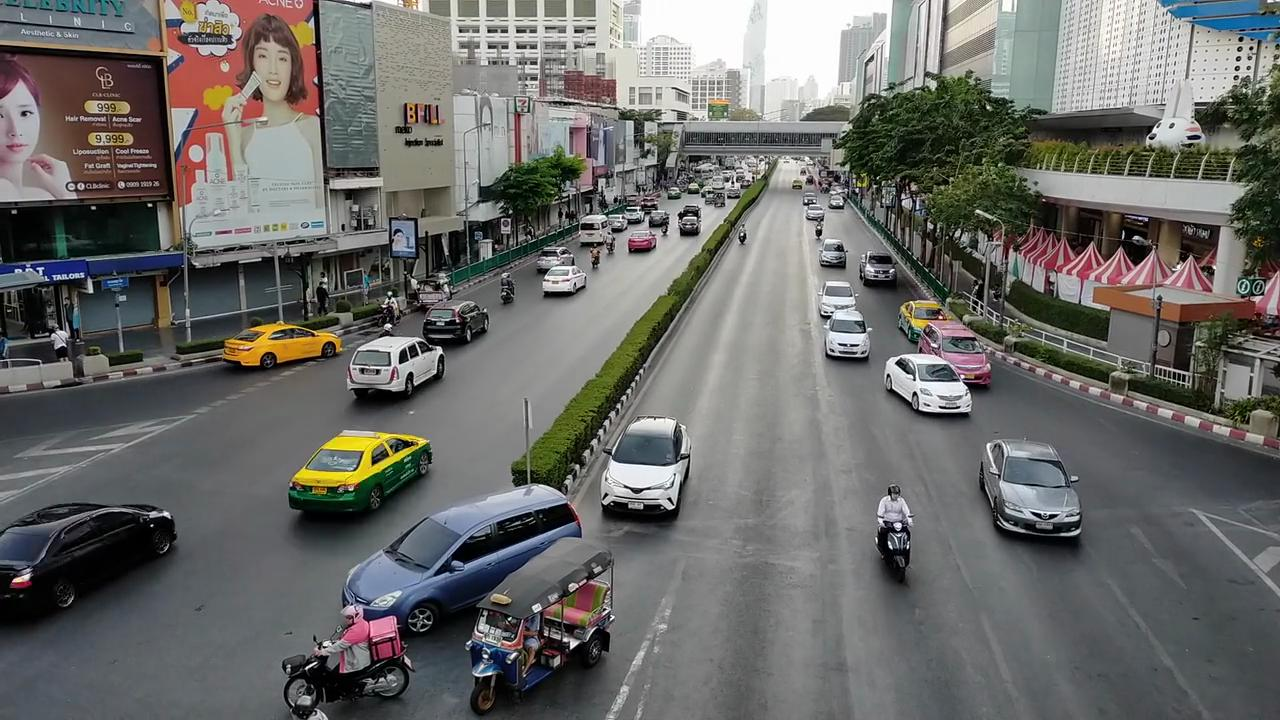

In [8]:
f.where(f.pos == 100).select(f.frame, f.frame.width, f.frame.height).show(1)

When we created the `video_data` table with automatic frame extraction, Pixeltable does not physically store the frames. Instead, Pixeltable re-extracts the frames on retrieval using the frame index, which can be done very efficiently and avoids any storage overhead (which would be very substantial for video frames).

## Object Detection as a user-defined function

User-defined functions let you customize Pixeltable's functionality for your own data.

In this example, we're going use a `torchvision` object detection model (Faster R-CNN):

In [9]:
import torch, torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")
_ = model.eval()  # switch to inference mode

Our function converts the image to PyTorch format and obtains a prediction from the model, which is a list of dictionaries with fields `boxes`, `labels`, and `scores` (one per input image). The fields themselves are PyTorch tensors, and we convert them to standard Python lists (so they become JSON-serializable data):

In [10]:
@pxt.udf(return_type=pxt.JsonType(), param_types=[pxt.ImageType()])
def detect(img):
    t = transforms.ToTensor()(img)
    t = transforms.ConvertImageDtype(torch.float)(t)
    result = model([t])[0]
    return {
        'boxes': result['boxes'].tolist(), 'labels': result['labels'].tolist(), 'scores': result['scores'].tolist()
    }

We can then use `detect()` in the Pixeltable index operator using standard Python function call syntax:

frame  \
0  <PIL.Image.Image image mode=RGB size=1280x720 ...   

                                               col_1  
0  {'boxes': [[337.8647155761719, 332.46612548828...
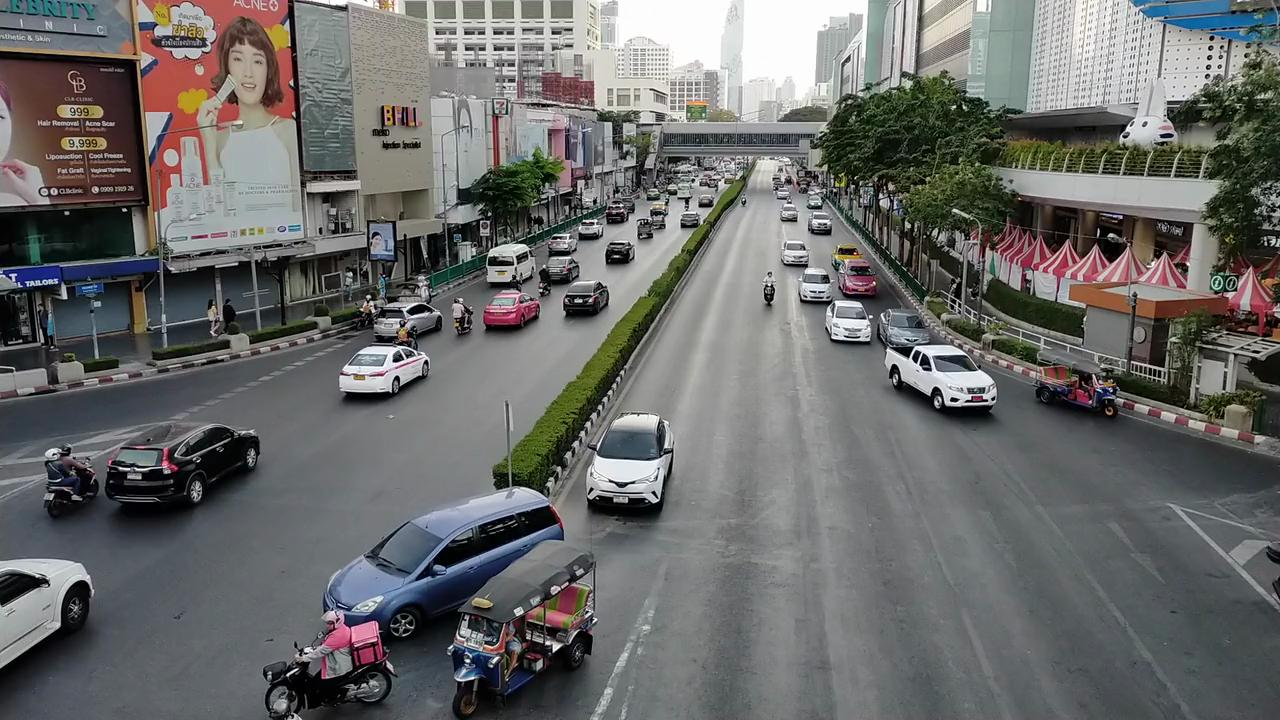

In [11]:
f.where(f.pos == 0).select(f.frame, detect(f.frame)).show(1)

This works as expected, and we now add the detections as a computed column `detections` to the table.

Running model inference is generally an expensive operation; adding it as a computed column makes sure it only runs once, at the time the row is inserted. After that, the result is available as part of the stored table data.

Note that for computed columns of any type other than `image`, the computed values are **always** stored (ie, `stored=True`).

In [12]:
f.add_column(detections=detect(f.frame))

Computing cells:   0%|          | 0/462 [00:00<?, ?cells/s]

Computing cells:   2%|▏         | 8/462 [00:02<02:08,  3.53cells/s]

Computing cells:   3%|▎         | 16/462 [00:04<02:08,  3.46cells/s]

Computing cells:   5%|▌         | 24/462 [00:07<02:08,  3.40cells/s]

Computing cells:   7%|▋         | 32/462 [00:09<02:06,  3.41cells/s]

Computing cells:   9%|▊         | 40/462 [00:11<02:03,  3.43cells/s]

Computing cells:  10%|█         | 48/462 [00:13<02:00,  3.43cells/s]

Computing cells:  12%|█▏        | 56/462 [00:16<01:58,  3.42cells/s]

Computing cells:  14%|█▍        | 64/462 [00:18<01:57,  3.39cells/s]

Computing cells:  16%|█▌        | 72/462 [00:21<01:56,  3.36cells/s]

Computing cells:  17%|█▋        | 80/462 [00:23<01:54,  3.35cells/s]

Computing cells:  19%|█▉        | 88/462 [00:26<01:52,  3.33cells/s]

Computing cells:  21%|██        | 96/462 [00:28<01:49,  3.35cells/s]

Computing cells:  23%|██▎       | 104/462 [00:30<01:47,  3.34cells/s]

Computing cells:  24%|██▍       | 112/462 [00:33<01:44,  3.35cells/s]

Computing cells:  26%|██▌       | 120/462 [00:35<01:40,  3.39cells/s]

Computing cells:  28%|██▊       | 128/462 [00:37<01:38,  3.40cells/s]

Computing cells:  29%|██▉       | 136/462 [00:40<01:36,  3.36cells/s]

Computing cells:  31%|███       | 144/462 [00:42<01:35,  3.34cells/s]

Computing cells:  33%|███▎      | 152/462 [00:45<01:33,  3.32cells/s]

Computing cells:  35%|███▍      | 160/462 [00:47<01:31,  3.32cells/s]

Computing cells:  36%|███▋      | 168/462 [00:49<01:28,  3.31cells/s]

Computing cells:  38%|███▊      | 176/462 [00:52<01:26,  3.31cells/s]

Computing cells:  40%|███▉      | 184/462 [00:54<01:24,  3.30cells/s]

Computing cells:  42%|████▏     | 192/462 [00:57<01:21,  3.33cells/s]

Computing cells:  43%|████▎     | 200/462 [00:59<01:18,  3.32cells/s]

Computing cells:  45%|████▌     | 208/462 [01:01<01:16,  3.32cells/s]

Computing cells:  47%|████▋     | 216/462 [01:04<01:14,  3.32cells/s]

Computing cells:  48%|████▊     | 224/462 [01:06<01:10,  3.38cells/s]

Computing cells:  50%|█████     | 232/462 [01:09<01:08,  3.35cells/s]

Computing cells:  52%|█████▏    | 240/462 [01:11<01:06,  3.33cells/s]

Computing cells:  54%|█████▎    | 248/462 [01:13<01:04,  3.33cells/s]

Computing cells:  55%|█████▌    | 256/462 [01:16<01:01,  3.32cells/s]

Computing cells:  57%|█████▋    | 264/462 [01:18<00:59,  3.35cells/s]

Computing cells:  59%|█████▉    | 272/462 [01:20<00:55,  3.41cells/s]

Computing cells:  61%|██████    | 280/462 [01:23<00:52,  3.44cells/s]

Computing cells:  62%|██████▏   | 288/462 [01:25<00:50,  3.43cells/s]

Computing cells:  64%|██████▍   | 296/462 [01:27<00:48,  3.45cells/s]

Computing cells:  66%|██████▌   | 304/462 [01:30<00:45,  3.47cells/s]

Computing cells:  68%|██████▊   | 312/462 [01:32<00:43,  3.42cells/s]

Computing cells:  69%|██████▉   | 320/462 [01:34<00:41,  3.41cells/s]

Computing cells:  71%|███████   | 328/462 [01:37<00:39,  3.41cells/s]

Computing cells:  73%|███████▎  | 336/462 [01:39<00:36,  3.42cells/s]

Computing cells:  74%|███████▍  | 344/462 [01:41<00:34,  3.45cells/s]

Computing cells:  76%|███████▌  | 352/462 [01:44<00:31,  3.46cells/s]

Computing cells:  78%|███████▊  | 360/462 [01:46<00:29,  3.46cells/s]

Computing cells:  80%|███████▉  | 368/462 [01:48<00:27,  3.48cells/s]

Computing cells:  81%|████████▏ | 376/462 [01:50<00:24,  3.50cells/s]

Computing cells:  83%|████████▎ | 384/462 [01:53<00:22,  3.50cells/s]

Computing cells:  85%|████████▍ | 392/462 [01:55<00:20,  3.50cells/s]

Computing cells:  87%|████████▋ | 400/462 [01:57<00:17,  3.50cells/s]

Computing cells:  88%|████████▊ | 408/462 [02:00<00:15,  3.49cells/s]

Computing cells:  90%|█████████ | 416/462 [02:02<00:13,  3.48cells/s]

Computing cells:  92%|█████████▏| 424/462 [02:04<00:11,  3.41cells/s]

Computing cells:  94%|█████████▎| 432/462 [02:07<00:08,  3.37cells/s]

Computing cells:  95%|█████████▌| 440/462 [02:09<00:06,  3.33cells/s]

Computing cells:  97%|█████████▋| 448/462 [02:12<00:04,  3.31cells/s]

Computing cells:  99%|█████████▊| 456/462 [02:14<00:01,  3.30cells/s]

Computing cells: 100%|██████████| 462/462 [02:16<00:00,  3.29cells/s]

Computing cells: 100%|██████████| 462/462 [02:16<00:00,  3.38cells/s]

added 462 column values with 0 errors


UpdateStatus(num_rows=462, num_computed_values=462, num_excs=0, updated_cols=[], cols_with_excs=[])

We can create a simple function `draw_boxes()` to visualize detections:

In [13]:
import PIL.ImageDraw

@pxt.udf(return_type=pxt.ImageType(), param_types=[pxt.ImageType(), pxt.JsonType()])
def draw_boxes(img, boxes):
    result = img.copy()
    d = PIL.ImageDraw.Draw(result)
    for box in boxes:
        d.rectangle(box, width=3)
    return result

This function takes two arguments:
- `img` has type `image` and receives an instance of `PIL.Image.Image`
- `boxes` has type `json` and receives a JSON-serializable structure, in this case a list of 4-element lists of floats

When we "call" this function, we need to pass in the frame and the bounding boxes identified in that frame. The latter can be selected with the JSON path expression `t.detections.boxes`:

frame,col_1
,

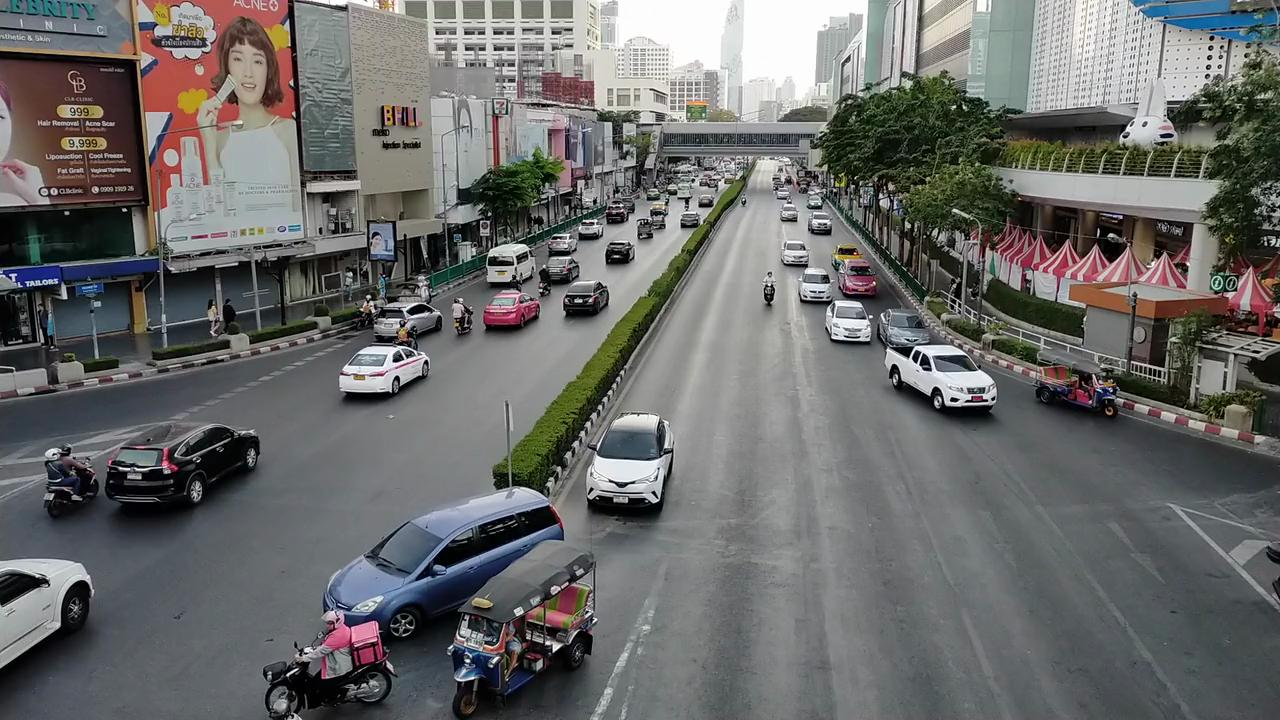
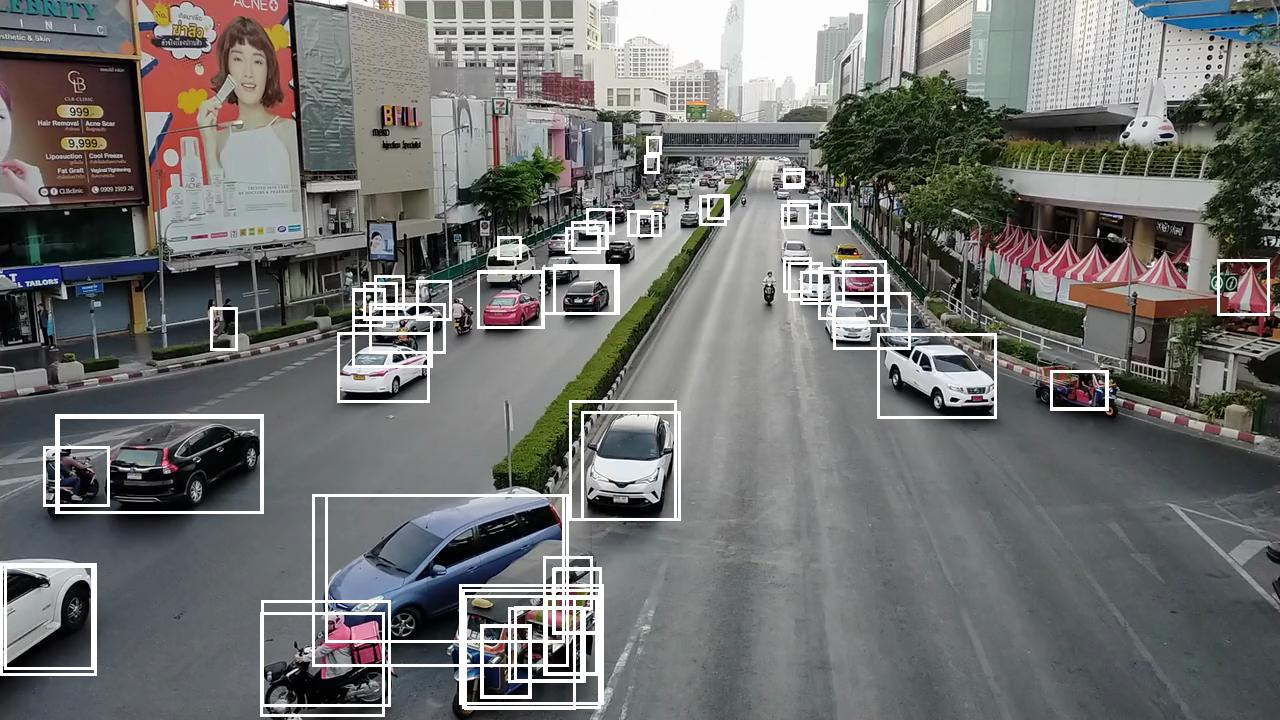

In [14]:
f.where(f.frame_idx == 0).select(f.frame, draw_boxes(f.frame, f.detections.boxes)).show(1)

Looking at individual frames gives us some idea of how well our detection algorithm works, but it would be more instructive to turn the visualization output back into a video.

We do that with the built-in function `make_video()`, which is an aggregation function that takes a frame index (actually: any expression that can be used to order the frames; a timestamp would also work) and an image, and then assembles the sequence of images into a video:

In [15]:
f.select(pxt.make_video(f.pos, draw_boxes(f.frame, f.detections.boxes))).group_by(v).show(1)

col_0
""
